# 1. Import Libraries

In [9]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D, Dropout,
    GlobalAveragePooling2D, Input, Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import collections
import hashlib
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from paddleocr import PaddleOCR
import cv2

In [3]:
!pip install paddleocr
!pip install paddlepaddle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=352ed1205c6325a56fee3f65fd6f2c247df39157024322054ba9dba0c878471d
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
   

# 2. Define Constants

In [3]:
# Constants
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 8
NUM_CLASSES = 2
TRAIN_PATH = '/content/drive/MyDrive/DATASET TRAIN'

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Utility Functions

In [ ]:
# Utility functions
def check_dataset_balance(generator):
    """
    Checks and prints the balance of classes in the dataset.
    """
    class_counts = {}
    for class_index in generator.classes:
        class_counts[class_index] = class_counts.get(class_index, 0) + 1

    total_samples = len(generator.classes)
    print(f"Dataset Distribution (Total Samples: {total_samples}):")
    for class_index, count in class_counts.items():
        class_name = list(generator.class_indices.keys())[list(generator.class_indices.values()).index(class_index)]
        print(f"Class {class_name}: {count} images ({(count / total_samples) * 100:.2f}%)")

def visualize_samples(generator, class_names, num_samples=5):
    """
    Visualize sample images from the generator.
    """
    batch_images, batch_labels = next(generator)
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(batch_images[i])
        plt.title(f"Class: {class_names[np.argmax(batch_labels[i])]}")
        plt.axis('off')
    plt.show()

def check_image_size_and_format(file_path, target_size):
    """
    Check the size and format of a single image.
    """
    try:
        with Image.open(file_path) as img:
            return (file_path, img.size) if img.size != target_size else None
    except Exception as e:
        return (file_path, str(e))

# 4. Data Generator Function

In [ ]:
# Data generator function
def create_data_generators():
    """
    Creates training and validation data generators with enhanced augmentation.
    """
    print("Creating data generators...")
    if not os.path.exists(TRAIN_PATH):
        raise ValueError(f"Training path not found: {TRAIN_PATH}")

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=[0.8, 1.5],
        brightness_range=[0.6, 1.4],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        classes=['Non Nutrition Facts', 'Nutrition Facts'],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        classes=['Non Nutrition Facts', 'Nutrition Facts'],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator


# 5. Main Execution to Create Data Generators

Creating data generators...
Found 3216 images belonging to 2 classes.
Found 802 images belonging to 2 classes.

Checking dataset balance:
Dataset Distribution (Total Samples: 3216):
Class Non Nutrition Facts: 1608 images (50.00%)
Class Nutrition Facts: 1608 images (50.00%)
Dataset Distribution (Total Samples: 802):
Class Non Nutrition Facts: 401 images (50.00%)
Class Nutrition Facts: 401 images (50.00%)

Visualizing sample images from the training set:


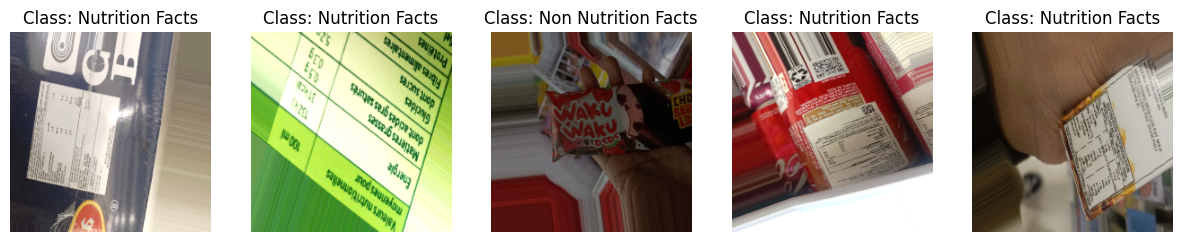


Dataset quality check completed. Proceed with preprocessing and training.


In [ ]:
# Main Execution
if __name__ == "__main__":
    train_generator, validation_generator = create_data_generators()

    # Step 1: Check dataset balance
    print("\nChecking dataset balance:")
    check_dataset_balance(train_generator)
    check_dataset_balance(validation_generator)

    # Step 2: Visualize sample images
    print("\nVisualizing sample images from the training set:")
    visualize_samples(train_generator, list(train_generator.class_indices.keys()), num_samples=5)

    print("\nDataset quality check completed. Proceed with preprocessing and training.")


# 6. Create CNN Model

In [ ]:
def create_simple_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    """
    Creates a simplified CNN model with dropout and L2 regularization.

    Args:
        input_shape (tuple): Shape of the input images (height, width, channels).
        num_classes (int): Number of output classes.

    Returns:
        Model: Compiled CNN model.
    """
    inputs = Input(shape=input_shape)

    # Block 1: Convolution + Pooling + Dropout
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 2: Convolution + Pooling + Dropout
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 3: Convolution + Pooling + Dropout
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)

    # Fully connected layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build and compile model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# 7. Plot Training History

In [ ]:
def plot_training_history(history):
    """
    Plots training and validation accuracy and loss.

    Args:
        history (History): The training history object returned by model.fit().
    """
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 8. Main Execution for Model Training and Evaluation

Creating data generators...
Found 3216 images belonging to 2 classes.
Found 802 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5193 - loss: 0.7131 - precision: 0.5193 - recall: 0.5193
Epoch 1: val_accuracy improved from -inf to 0.53491, saving model to nutrition_model-001-0.5349.keras
402/402 ━━━━━━━━━━━━━━━━━━━━ 2153s 5s/step - accuracy: 0.5194 - loss: 0.7131 - precision: 0.5194 - recall: 0.5194 - val_accuracy: 0.5349 - val_loss: 0.7014 - val_precision: 0.5349 - val_recall: 0.5349 - learning_rate: 0.0010
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6067 - loss: 0.6752 - precision: 0.6067 - recall: 0.6067
Epoch 2: val_accuracy improved from 0.53491 to 0.66708, saving model to nutrition_model-002-0.6671.keras
402/402 ━━━━━━━━━━━━━━━━━━━━ 1678s 4s/step - accuracy: 0.6068 - loss: 0.6751 - precision: 0.6068 - recall: 0.6068 - val_accuracy: 0.6671 - val_loss: 0.6217 - val_precision: 0.6671 - val_recall: 0.6671 - learning_rate: 0.0010
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7291 - loss: 0.5750 - precision: 0.7291 - rec

Model saved as 'final_nutrition_model.h5'.


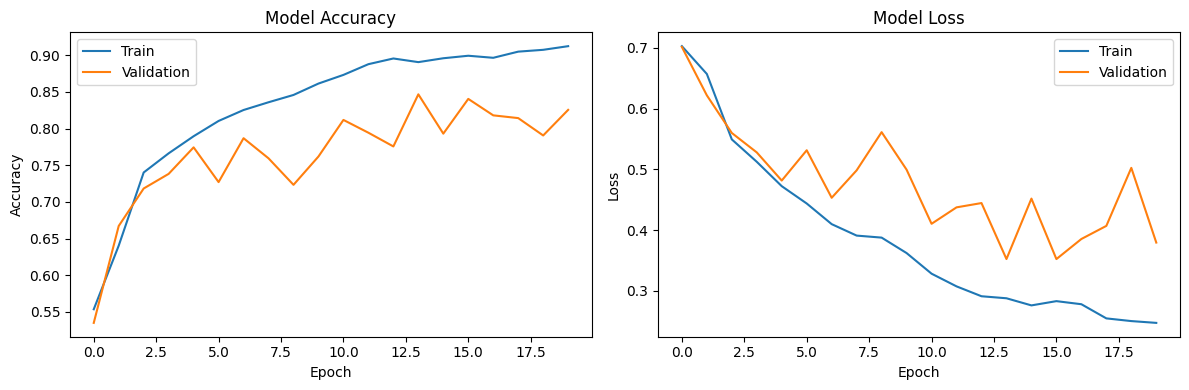

101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8359 - loss: 0.3876 - precision: 0.8359 - recall: 0.8359
Validation Loss: 0.3505
Validation Accuracy: 0.8416
Validation Precision: 0.8416
Validation Recall: 0.8416
101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step
Validation F1-Score: 0.8550

Classification Report:
                     precision    recall  f1-score   support

Non Nutrition Facts       0.90      0.80      0.85       401
    Nutrition Facts       0.82      0.91      0.86       401

           accuracy                           0.86       802
          macro avg       0.86      0.86      0.85       802
       weighted avg       0.86      0.86      0.85       802



In [ ]:
# Main Execution
if __name__ == "__main__":

    # Create data generators
    train_generator, validation_generator = create_data_generators()

    if train_generator and validation_generator:

        # Create CNN model
        model = create_simple_cnn()

        # Define Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )

        checkpoint = ModelCheckpoint(
            'nutrition_model-{epoch:03d}-{val_accuracy:.4f}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )

        # Train the model
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=20,
            callbacks=[checkpoint, early_stopping, reduce_lr]
        )

        # Save the final model
        model.save('final_nutrition_model.h5')
        print("Model saved as 'final_nutrition_model.h5'.")

        # Plot training history
        plot_training_history(history)

        # Evaluate model on validation set
        val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_generator)
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation Precision: {val_precision:.4f}")
        print(f"Validation Recall: {val_recall:.4f}")

        # Calculate F1-Score and classification report
        val_preds = model.predict(validation_generator)
        val_y_true = validation_generator.classes
        val_y_pred = np.argmax(val_preds, axis=-1)

        f1 = f1_score(val_y_true, val_y_pred, average='weighted')
        print(f"Validation F1-Score: {f1:.4f}")
        print("\nClassification Report:")
        print(classification_report(val_y_true, val_y_pred, target_names=['Non Nutrition Facts', 'Nutrition Facts']))

    else:
        print("Failed to create data generators.")


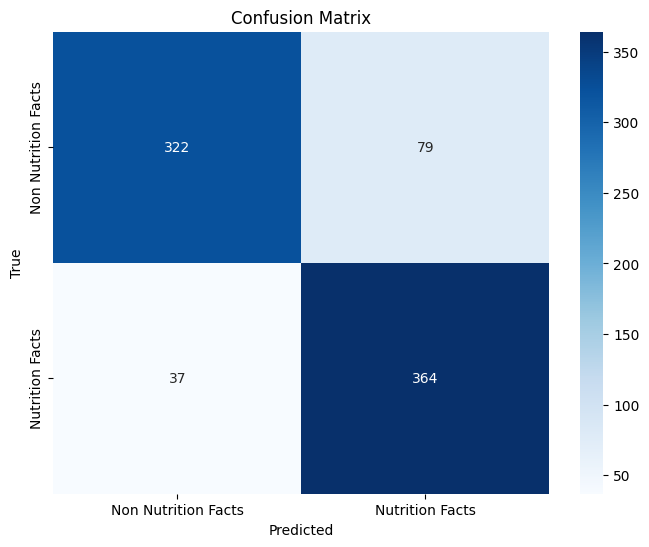

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(val_y_true, val_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Nutrition Facts', 'Nutrition Facts'], yticklabels=['Non Nutrition Facts', 'Nutrition Facts'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


101/101 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step


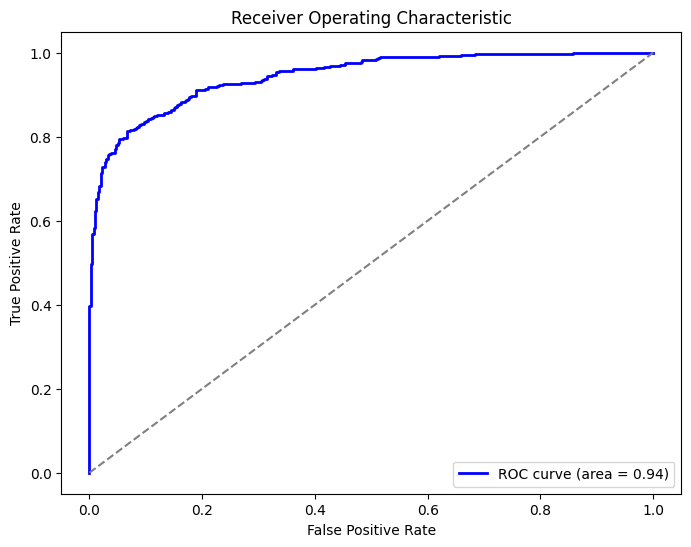

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(y_true, y_pred_prob, class_labels):
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=[0, 1])

    # Compute ROC curve and AUC for each class
    fpr, tpr, thresholds = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Predict probabilities for ROC
val_preds_prob = model.predict(validation_generator)

plot_roc_curve(val_y_true, val_preds_prob[:, 1], ['Non Nutrition Facts', 'Nutrition Facts'])


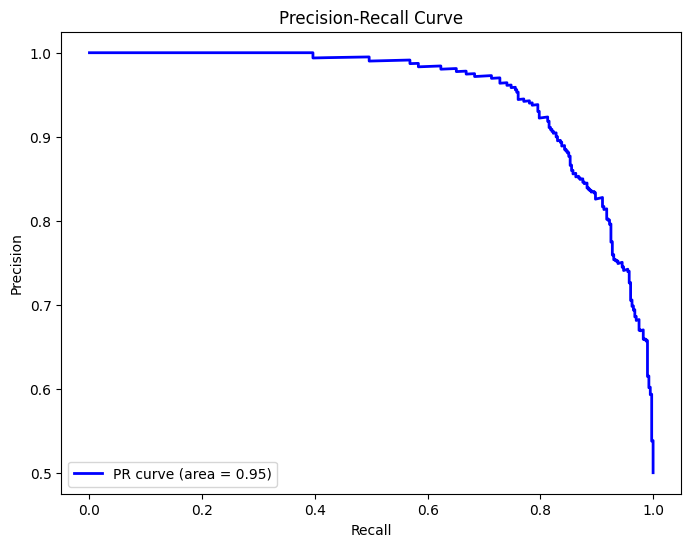

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(y_true, y_pred_prob, class_labels):
    # Compute Precision-Recall curve and AUC
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# Predict probabilities for Precision-Recall
plot_precision_recall_curve(val_y_true, val_preds_prob[:, 1], ['Non Nutrition Facts', 'Nutrition Facts'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted Class: Nutrition Facts
Confidence: 69.96%


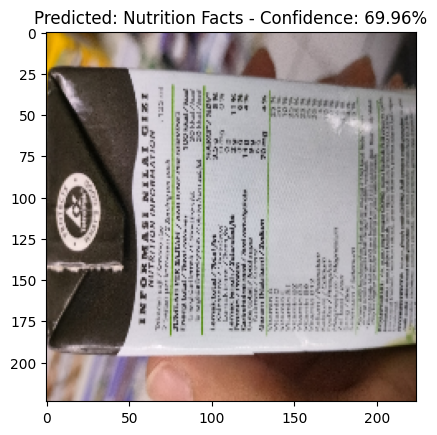

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted Class: Nutrition Facts
Confidence: 86.51%


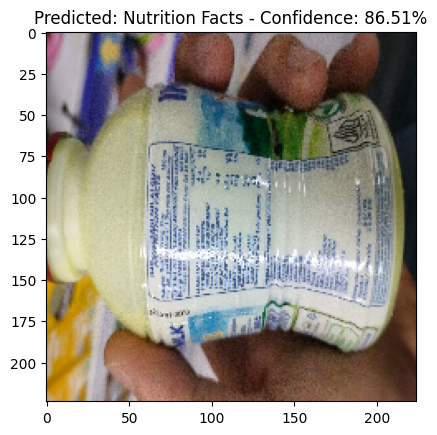

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted Class: Nutrition Facts
Confidence: 57.62%


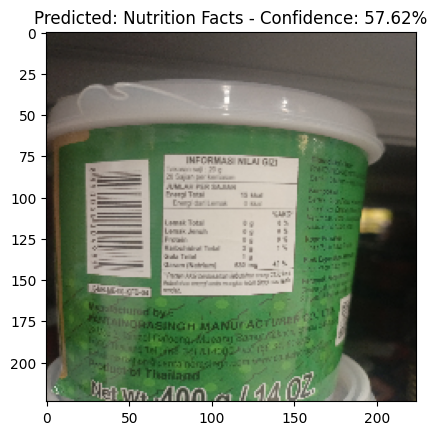

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted Class: Non Nutrition Facts
Confidence: 84.56%


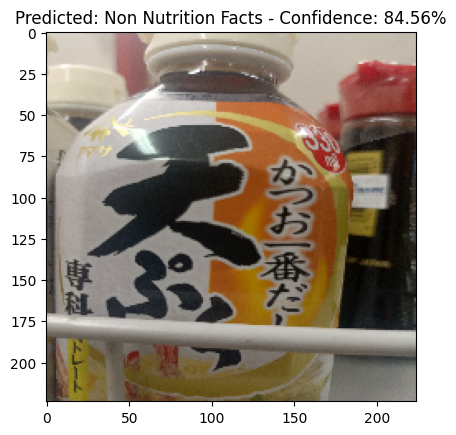

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted Class: Non Nutrition Facts
Confidence: 64.05%


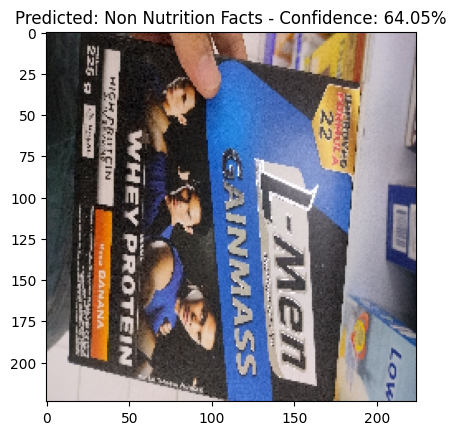

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Class: Non Nutrition Facts
Confidence: 88.38%


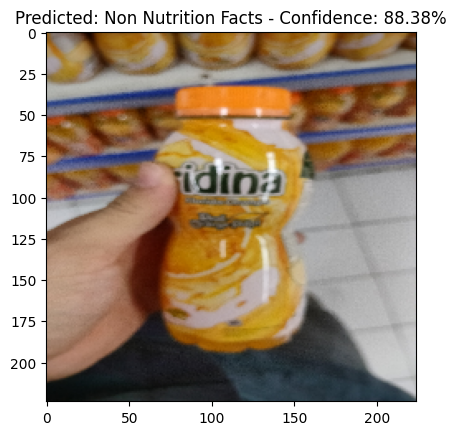

In [ ]:
def predict_on_new_images(model, image_paths, img_height=224, img_width=224):
    for img_path in image_paths:
        load_and_predict_image(img_path, model, img_height, img_width)

# Example usage:
new_image_paths = [
    '/content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG20241113171035.jpg',
    '/content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG20241113171228.jpg',
    '/content/drive/MyDrive/DATASET TRAIN/Nutrition Facts/IMG_20241122_150023_648.jpg',
    '/content/drive/MyDrive/DATASET TRAIN/Non Nutrition Facts/IMG_20241126_165402_305.jpg',
    '/content/drive/MyDrive/DATASET TRAIN/Non Nutrition Facts/IMG20241113170652.jpg',
    '/content/drive/MyDrive/DATASET TRAIN/Non Nutrition Facts/IMG20241113174057.jpg'


]
predict_on_new_images(model, new_image_paths)


In [5]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/final_nutrition_model_ML.h5')

In [10]:
def detect_nutrition_facts(image_path, model):
    """Fungsi deteksi dengan preprocessing yang lebih baik"""
    img = cv2.imread(image_path)
    if img is None:
        return None, 0.0, None

    img_orig = img.copy()

    # Preprocessing yang lebih baik
    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    blurred = cv2.bilateralFilter(enhanced, 9, 75, 75)
    binary = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15,
        2
    )

    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    nutrition_box = None
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

        if len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            area_ratio = (w * h) / (img.shape[0] * img .shape[1])

            if 0.4 <= aspect_ratio <= 2.5 and 0.05 <= area_ratio <= 0.9:
                nutrition_box = approx
                break

    if nutrition_box is not None:
        cv2.drawContours(img_orig, [nutrition_box], -1, (0, 255, 0), 2)

        mask = np.zeros(gray.shape, dtype=np.uint8)
        cv2.drawContours(mask, [nutrition_box], -1, (255), -1)
        result = cv2.bitwise_and(img_orig, img_orig, mask=mask)

        result = cv2.resize(result, (IMG_WIDTH, IMG_HEIGHT))
        result = result / 255.0
        result = np.expand_dims(result, axis=0)

        prediction = model.predict(result)
        class_index = np.argmax(prediction, axis=1)[0]
        confidence = prediction[0][class_index]

        predicted_class = 'Nutrition Fact' if class_index == 1 else 'Non Nutrition Fact'

        return img_orig, confidence, predicted_class, nutrition_box

    return img_orig, 0.0, None, None

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted Class: Nutrition Facts
Confidence: 99.96%


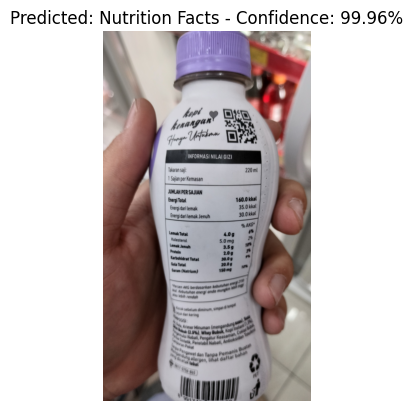

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


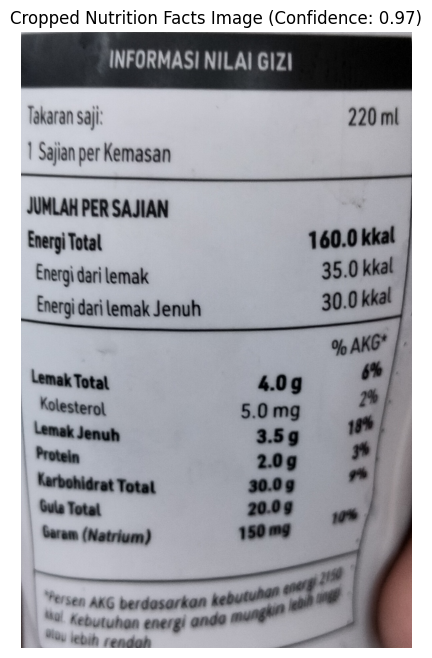

In [36]:
def load_and_predict_image(image_path, model, img_height=224, img_width=224):
    """
    Loads an image, preprocesses it, and makes a prediction using the trained model.
    """
    # Load the image for prediction
    img_for_pred = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img_for_pred) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Load the image for display (original size)
    img_for_display = image.load_img(image_path)

    # Make the prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    confidence = np.max(predictions) * 100  # Max probability in percentage
    class_labels = ['Non Nutrition Facts', 'Nutrition Facts']

    print(f"Predicted Class: {class_labels[predicted_class[0]]}")
    print(f"Confidence: {confidence:.2f}%")

    # Display the image in its original size
    plt.imshow(img_for_display)
    plt.title(f"Predicted: {class_labels[predicted_class[0]]} - Confidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

    return class_labels[predicted_class[0]], confidence

def crop_nutrition_facts(image_path, contour):
    """
    Crops an image based on the bounding rectangle of a given contour.
    """
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image could not be loaded.")
        return None

    # Crop based on the bounding box
    x, y, w, h = cv2.boundingRect(contour)
    cropped_image = img[y:y+h, x:x+w]

    return cropped_image

def detect_and_crop(image_path, model, detect_func, img_height=224, img_width=224):
    """
    Detects nutrition facts in an image, predicts its presence, and crops the relevant region.
    """
    if not os.path.exists(image_path):
        print(f"Error: The image file does not exist at the specified path: {image_path}")
        return

    # Prediction and detection
    predicted_class, confidence = load_and_predict_image(image_path, model, img_height, img_width)

    cropped_image = None

    if predicted_class == "Nutrition Facts":
        result_image, confidence, predicted_class, contour = detect_func(image_path, model)
        if contour is not None:
            cropped_image = crop_nutrition_facts(image_path, contour)

            # Display the cropped image
            if cropped_image is not None:
                plt.figure(figsize=(10, 8))
                plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
                plt.title(f'Cropped Nutrition Facts Image (Confidence: {confidence:.2f})')
                plt.axis('off')
                plt.show()
        else:
            print("No nutrition facts detected in the image.")
    else:
        print("Prediction indicates the image does not contain Nutrition Facts.")

    return cropped_image


# Example usage:
test_image_path = "/content/drive/MyDrive/Tes Captone/IMG20241111150416.jpg"  # Replace with your test image path
cropped_image = detect_and_crop(test_image_path, loaded_model, detect_nutrition_facts)


In [37]:
#PaddleOCR dengan bahasa Indonesia
ocr = PaddleOCR(use_angle_cls=True, lang='id')

# library gambar
image_path = cropped_image

# Proses OCR
results = ocr.ocr(image_path, cls=True)

# Menyaring hasil untuk kata "Gula" dan kandungan dalam gram (g)
kandungan_gula = []
for i, line in enumerate(results[0]):
    text = line[1][0]  # hasil ocr
    if "Gula" in text or "gula" in text:  # mencari kata gula
        # Cek kandungan gula ke teks terdekat
        if i + 1 < len(results[0]):
            next_text = results[0][i + 1][1][0]
            if "g" in next_text and any(char.isdigit() for char in next_text):  # mencari angka dan 'g' setelah teks gula
                kandungan_gula.append((text, next_text))  # Simpan "Gula" dan kandungannya

print("Kandungan gula")
for gula, kandungan in kandungan_gula:
    print(f"{gula}: {kandungan}")

[2024/12/03 12:45:12] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25,